<a href="https://colab.research.google.com/github/DonghaeSuh/NLP_tensorflow2/blob/main/7_PRETRAIN_METHOD/GPT2/GPT2_NSMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 여러 도구들 install

In [1]:
pip install sentencepiece==0.1.85

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 31.9 MB/s 


In [2]:
pip install gluonnlp==0.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 252 kB 34.4 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.9.1-cp37-cp37m-linux_x86_64.whl size=472279 sha256=eb2836e73516220380b04cb4de1d18b9bc3f450908b5a5042a2900dfaec5319a
  Stored in directory: /root/.cache/pip/wheels/d7/dd/b2/c023f6c9c83fb46b10f62f77ea526c4dad6913b967941bbe99
Successfully built gluonnlp


In [3]:
pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 1.1 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [4]:
pip install transformers==3.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 769 kB 31.8 MB/s 
     |████████████████████████████████| 3.0 MB 56.5 MB/s 
     |████████████████████████████████| 880 kB 50.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=22f50dd09f146b4bffef70d17044c6866e8b4ae5676863ecec5813f9a5a790fe
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


## 시작

In [5]:
import os
import tensorflow as tf
from transformers import TFGPT2Model

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import re

In [7]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)

In [9]:
cd drive/MyDrive/GPT

/content/drive/MyDrive/GPT


In [10]:
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token='<unused0>',
                                               cls_token=None,
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')

In [11]:
BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.1
SENT_MAX_LEN = 39

DATA_IN_PATH = './data_in'
DATA_OUT_PATH = "./data_out"

## 데이터 준비하기

In [12]:
# 데이터 전처리 준비

DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_train.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_test.txt")

train_data = pd.read_csv(DATA_TRAIN_PATH, header = 0, delimiter = '\t', quoting = 3)
train_data = train_data.dropna()
train_data.head()

print("Total # dataset: train - {}".format(len(train_data)))

Total # dataset: train - 149995


In [13]:
# 텍스트 전처리

def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", sent)
    return sent_clean

In [14]:
# train_data = train_data[:50] # for test

train_data_sents = []
train_data_labels = []

for train_sent, train_label in train_data[['document', 'label']].values:
    train_tokenized_text = vocab[tokenizer(clean_text(train_sent))]

    tokens = [vocab[vocab.bos_token]]  
    tokens += pad_sequences([train_tokenized_text], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.eos_token]]

    train_data_sents.append(tokens)
    train_data_labels.append(train_label)

train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)

## 모델 학습

In [15]:
class TFGPT2Classifier(tf.keras.Model):
    def __init__(self, dir_path, num_class):
        super(TFGPT2Classifier, self).__init__()
        
        self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
        self.num_class = num_class
        
        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(self.num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs):
        outputs = self.gpt2(inputs)
        pooled_output = outputs[0][:, -1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits

In [16]:
BASE_MODEL_PATH = './gpt_ckpt'
cls_model = TFGPT2Classifier(dir_path=BASE_MODEL_PATH, num_class=2)


If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=6.25e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [18]:
model_name = "tf2_gpt2_naver_movie"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = cls_model.fit(train_data_sents, train_data_labels, 
                        epochs=NUM_EPOCHS, 
                        batch_size=BATCH_SIZE,
                        validation_split=VALID_SPLIT, 
                        callbacks=[earlystop_callback, cp_callback])

./data_out/tf2_gpt2_naver_movie -- Folder create complete 

Epoch 1/3
4219/4219 [==============================] - ETA: 0s - loss: 0.3219 - accuracy: 0.8571
Epoch 1: val_accuracy improved from -inf to 0.88613, saving model to ./data_out/tf2_gpt2_naver_movie/weights.h5
4219/4219 [==============================] - 1274s 297ms/step - loss: 0.3219 - accuracy: 0.8571 - val_loss: 0.2651 - val_accuracy: 0.8861
Epoch 2/3
4219/4219 [==============================] - ETA: 0s - loss: 0.2334 - accuracy: 0.9032
Epoch 2: val_accuracy improved from 0.88613 to 0.89007, saving model to ./data_out/tf2_gpt2_naver_movie/weights.h5
4219/4219 [==============================] - 1257s 298ms/step - loss: 0.2334 - accuracy: 0.9032 - val_loss: 0.2618 - val_accuracy: 0.8901
Epoch 3/3
4219/4219 [==============================] - ETA: 0s - loss: 0.1751 - accuracy: 0.9298
Epoch 3: val_accuracy did not improve from 0.89007
4219/4219 [==============================] - 1253s 297ms/step - loss: 0.1751 - accuracy: 0.9298

In [6]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

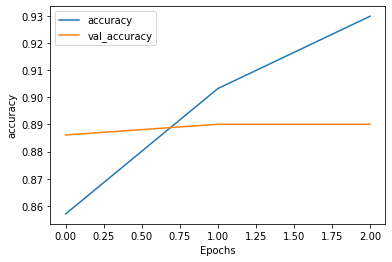

In [19]:
plot_graphs(history, 'accuracy')

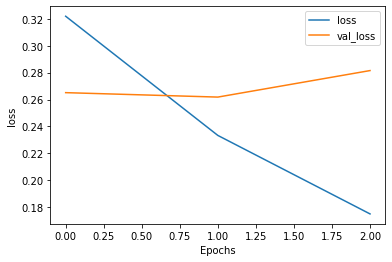

In [20]:
plot_graphs(history, 'loss')

## 모델 테스트

In [21]:
test_data = pd.read_csv(DATA_TEST_PATH, header=0, delimiter='\t', quoting=3)
test_data = test_data.dropna()
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [22]:
# test_data = test_data[:50] # for test

test_data_sents = []
test_data_labels = []

for test_sent, test_label in test_data[['document','label']].values:
    test_tokenized_text = vocab[tokenizer(clean_text(test_sent))]

    tokens = [vocab[vocab.bos_token]]  
    tokens += pad_sequences([test_tokenized_text], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.eos_token]]

    test_data_sents.append(tokens)
    test_data_labels.append(test_label)

test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [23]:
print("num sents, labels {}, {}".format(len(test_data_sents), len(test_data_labels)))

num sents, labels 49997, 49997


In [24]:
cls_model.load_weights(checkpoint_path)

results = cls_model.evaluate(test_data_sents, test_data_labels, batch_size=1024)
print("test loss, test acc: ", results)

49/49 [==============================] - 141s 3s/step - loss: 0.2702 - accuracy: 0.8877
test loss, test acc:  [0.2702365219593048, 0.8877132534980774]
